### 1. load data
### 2. split into train/test by time
### 3.1. train scaler_x on the x_train (use StandardScaler!)
3.2. train scaler_y on the y_train

4.1. Apply scaler_x to x_train and x_test => x_train_scaled, x_test_scaled
4.2. Apply scaler_y to y_train and y_test => y_train_scaled, y_test_scaled
5. Make TimeseriesGenerator for x_train_scaled and y_train_scaled for the window=168 => x_train_window, y_train_window
6. Train https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html using x_train_window as inputs and y_train_window as target => model
7. Compute predictions of the model for scaled datasets => pred_train_scaled, pred_test_scaled
8. Reverse predictions using function inverse_transform for the scaler => pred_train, pred_test
9. Compute evaluations: MSE and MAPE



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from datetime import datetime
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# univariate one step problem with mlp
# from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import TimeseriesGenerator

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c356b78d0>,
      dtype=object)

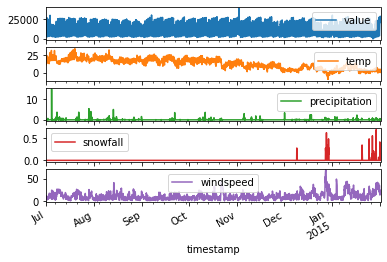

In [2]:
data = pd.read_csv('nyc_taxi_3.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
data.set_index('timestamp')[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']].plot(subplots=True)

In [3]:
# data.set_index('timestamp')[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']]
# #타임스탬프를 빼준 데이터
# data_input = data[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']]
data_input = data[['value', 'temp', 'precipitation', 'snowfall', 'windspeed']]


In [4]:
data_input

,value,temp,precipitation,snowfall,windspeed
0,10844,14.370529,0.0,0.00,4.104631
1,6210,13.450529,0.0,0.00,4.104631
2,3820,12.840529,0.0,0.00,3.396233
3,2369,12.160529,0.0,0.00,4.394360
4,2221,11.540529,0.0,0.00,5.959060
...,...,...,...,...,...
5155,28804,2.700529,0.2,0.14,20.929596
5156,24985,2.030528,0.0,0.00,20.880001
5157,23719,1.660529,0.0,0.00,19.469976
5158,25721,1.180529,0.0,0.00,15.379206


## Split into train test sets  
## 이상적으로 원본 데이터 세트를 입력 X 출력 Y로 분할 

In [5]:
# split a dataset into train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
# create dataset
x = data_input.values 
                                                                        # [Start:End]
X, y = x[:,:5], x[:,0]                                           # [:  (세로), :   (가로)]
# split into train test sets 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=1, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4128, 5) (1032, 5) (4128,) (1032,)


In [6]:
x_train #(4128, 5)

array([[1.0844000e+04, 1.4370529e+01, 0.0000000e+00, 0.0000000e+00,
        4.1046314e+00],
       [6.2100000e+03, 1.3450529e+01, 0.0000000e+00, 0.0000000e+00,
        4.1046314e+00],
       [3.8200000e+03, 1.2840529e+01, 0.0000000e+00, 0.0000000e+00,
        3.3962330e+00],
       ...,
       [2.6280000e+04, 1.1670529e+01, 0.0000000e+00, 0.0000000e+00,
        3.5834015e+01],
       [2.6905000e+04, 1.1420529e+01, 1.0000000e-01, 0.0000000e+00,
        3.5647274e+01],
       [2.5807000e+04, 1.0860529e+01, 1.0000000e-01, 0.0000000e+00,
        3.5452232e+01]])

In [7]:
x_test #(1032, 5)

array([[2.5976000e+04, 9.7205290e+00, 0.0000000e+00, 0.0000000e+00,
        1.8089775e+01],
       [2.2993000e+04, 8.2905290e+00, 0.0000000e+00, 0.0000000e+00,
        1.5077082e+01],
       [1.9390000e+04, 7.5705285e+00, 0.0000000e+00, 0.0000000e+00,
        1.4241630e+01],
       ...,
       [2.3719000e+04, 1.6605287e+00, 0.0000000e+00, 0.0000000e+00,
        1.9469976e+01],
       [2.5721000e+04, 1.1805286e+00, 0.0000000e+00, 0.0000000e+00,
        1.5379206e+01],
       [2.6591000e+04, 5.3052866e-01, 0.0000000e+00, 0.0000000e+00,
        1.6548256e+01]])

In [8]:
y_train#(4128, )

array([10844.,  6210.,  3820., ..., 26280., 26905., 25807.])

In [9]:
y_test #(1032,)

array([25976., 22993., 19390., ..., 23719., 25721., 26591.])

In [10]:
from sklearn.preprocessing import StandardScaler   
#fit_transfrom 을 사용하면 transform이랑 fit 이랑 따로 쓰는걸 사용 안해도 된다 
#
scaler = StandardScaler() # #fit 메서드에 훈련 데이터를 적용한다 (fit 으로 scaler를 학습한다고 생각하면된다 )
scaler.fit(x_train)

y_train = y_train.reshape(-1,1)
scaler.fit(y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# Apply scaler_x to x_train and x_test => x_train_scaled, x_test_scaled
# transform 변환만을 해주니까 transform만 사용 (pandas datafram으로 바꿔준거)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#Apply scaler_y to y_train and y_test => y_train_scaled, y_test_scaled
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test.reshape(-1,1))


In [12]:
x_test_scaled.shape #

(1032, 5)

In [13]:
y_test_scaled.shape

(1032, 1)

In [14]:
# x_train

In [15]:
# y_train 

In [16]:
# scaler_y

In [17]:
print(x_train_scaled)
print("-----------")
print(x_test_scaled)
print("-----------")
print(y_train_scaled)
print("-----------")
print(y_test_scaled)

[[-0.65804515 -2.23265677 -2.23474622 -2.23474622 -2.23414942]
 [-1.33182169 -2.23279054 -2.23474622 -2.23474622 -2.23414942]
 [-1.67932405 -2.23287923 -2.23474622 -2.23474622 -2.23425242]
 ...
 [ 1.58632573 -2.23304935 -2.23474622 -2.23474622 -2.22953601]
 [ 1.67719978 -2.2330857  -2.23473168 -2.23474622 -2.22956317]
 [ 1.51755225 -2.23316712 -2.23473168 -2.23474622 -2.22959152]]
-----------
[[ 1.54212459 -2.23333287 -2.23474622 -2.23474622 -2.232116  ]
 [ 1.10840094 -2.23354079 -2.23474622 -2.23474622 -2.23255404]
 [ 0.58453023 -2.23364548 -2.23474622 -2.23474622 -2.23267551]
 ...
 [ 1.21396023 -2.23450479 -2.23474622 -2.23474622 -2.23191532]
 [ 1.50504798 -2.23457458 -2.23474622 -2.23474622 -2.23251011]
 [ 1.63154466 -2.23466909 -2.23474622 -2.23474622 -2.23234013]]
-----------
[[-0.65804515]
 [-1.33182169]
 [-1.67932405]
 ...
 [ 1.58632573]
 [ 1.67719978]
 [ 1.51755225]]
-----------
[[1.54212459]
 [1.10840094]
 [0.58453023]
 ...
 [1.21396023]
 [1.50504798]
 [1.63154466]]


In [38]:
# + LR  Batch- > 나누기  generating batches of temporal data. 임시데이터 배치 
# ex  ==>   TSGenrator( data 연속적인 데이터 포인트 2D에 있어야한다 
#                                     targets은 시간단계에 해당되는거 길이는 Data 길이
#                                     length 출력 시퀀스 길이 
#                                     Sampling_rate = 속도를 말하는거다 시간 단계사이의 기간 
#                                     Batch_size 마지막 항목을 제외시킨다 그리고 각 배치의 timeseries샘플 수  )

x_train_window = TimeseriesGenerator(x_train_scaled, y_train_scaled[:,0], length=168, sampling_rate=1, batch_size=1) # 80% ->124?
x_test_window = TimeseriesGenerator(x_test_scaled, y_test_scaled[:,0], length=168, sampling_rate=1, batch_size=1) # 20% -> 27?

In [39]:
# x_train_window[0]
# len(x_train_window) == 168 
# x_window = np.array(x_train_window)
# len(x_window)
# numpy.array 타입으로 넣어봄
# 80% 트레이닝 
batch = x_train_window[0] 
# print(train_generator_AR[0][0]) ## --> divide x_train_scaled, y_train_scaled, 
# in that, there are 1 batches, in that, 
# here are 168 window size of the data.

# print(batch)
x, y = batch
# print(len(x))
input_arr = []
output_arr = []
for batch in x_train_window:
  x, y = batch
  xr = x.ravel() # (1, 168, 5) --> (840)
  yr = y.ravel() # (1,) --> (1 )
  input_arr.append(xr)
  output_arr.append(yr)
  # print(x.shape) # (1, 336, 5))
  # print(y.shape) # (1,) * 336

In [40]:
xr.shape
yr.shape
# xr = input_arr
# yr = output_arr
# x_arr = input_arr
# y_arr = output_arr

(1,)

In [41]:
# test  20% test 값
batch = x_test_window[0]
x, y = batch 

input_arr_test = []
output_arr_test = []
for batch in x_test_window:
  x, y = batch
  xr_test = x.ravel()
  yr_test = y.ravel()
  input_arr_test.append(xr_test)
  output_arr_test.append(yr_test)

# print(input_arr_test, output_arr_test)

In [42]:
#80%
x_arr = np.array(input_arr)
y_arr = np.array(output_arr)
#20%
xr_test = np.array(input_arr_test)
yr_test = np.array(output_arr_test)


In [43]:
xr_test.shape ## xr_test = input_arr_test 

(864, 840)

In [44]:
yr.shape ## yr_test = output_arr_test

(1,)

In [45]:
# x_arr = input_arr = xr --> (1, 168, 5)
# y_arr = output_arr = yr --> (1, )

# xr_test = input_arr_test = xr_test --> (864, 840)
# yr_test = output_arr_test = yr_test --> (1, )

model = LinearRegression().fit(x_arr,y_arr)

In [46]:
y_pred = model.predict(xr_test) #x_arr #예측을 하는곳에 우선 트레이닝 해야하는 값이다 # x_arr
print(x_arr.shape)
# print(y_pred.shape)
# pred.shape

y_pred_test = model.predict(xr_test) #x_arr #예측을 하는곳에 우선 트레이닝 해야하는 값이다
# print(x_arr.shape), print(y_pred.shape)
y_pred_test.shape

(3960, 840)


(864, 1)

In [47]:
# xr_test -> (864,840 ) 모든부분을 다봐준다. *다시
x_data = yr_test[:,:]
x_data.shape

# x_data = xr_test[:,1:][336:]

(864, 1)

In [48]:
# test_win_length_after = x_test_scaled[:,1:][336:]
data_pred = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(xr_test)],axis=1)
data_pred

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839
0,0.058094,1.542125,-2.233333,-2.234746,-2.234746,-2.232116,1.108401,-2.233541,-2.234746,-2.234746,-2.232554,0.584530,-2.233645,-2.234746,-2.234746,-2.232676,-0.154385,-2.233709,-2.234746,-2.234746,-2.232929,-0.661244,-2.233855,-2.234746,-2.234746,-2.233162,-1.558934,-2.233795,-2.234746,-2.234746,-2.233006,-1.641520,-2.233955,-2.234746,-2.234746,-2.233172,-1.532035,-2.233955,-2.234746,-2.234746,...,0.016168,-2.234220,-2.234746,-2.234746,-2.232474,0.033034,-2.234383,-2.234746,-2.234746,-2.233006,0.195008,-2.234525,-2.234746,-2.234746,-2.233486,0.398856,-2.234624,-2.234746,-2.234746,-2.233653,-0.041119,-2.234701,-2.234746,-2.234746,-2.233626,-0.083285,-2.234745,-2.234746,-2.234746,-2.233739,0.036087,-2.234814,-2.234746,-2.234746,-2.233750,-0.073689,-2.234822,-2.234746,-2.234746,-2.233784
1,-0.145979,1.108401,-2.233541,-2.234746,-2.234746,-2.232554,0.584530,-2.233645,-2.234746,-2.234746,-2.232676,-0.154385,-2.233709,-2.234746,-2.234746,-2.232929,-0.661244,-2.233855,-2.234746,-2.234746,-2.233162,-1.558934,-2.233795,-2.234746,-2.234746,-2.233006,-1.641520,-2.233955,-2.234746,-2.234746,-2.233172,-1.532035,-2.233955,-2.234746,-2.234746,-2.232967,-1.134371,-2.234013,-2.234746,-2.234746,...,0.033034,-2.234383,-2.234746,-2.234746,-2.233006,0.195008,-2.234525,-2.234746,-2.234746,-2.233486,0.398856,-2.234624,-2.234746,-2.234746,-2.233653,-0.041119,-2.234701,-2.234746,-2.234746,-2.233626,-0.083285,-2.234745,-2.234746,-2.234746,-2.233739,0.036087,-2.234814,-2.234746,-2.234746,-2.233750,-0.073689,-2.234822,-2.234746,-2.234746,-2.233784,-0.286988,-2.234813,-2.234746,-2.234746,-2.233637
2,-0.543327,0.584530,-2.233645,-2.234746,-2.234746,-2.232676,-0.154385,-2.233709,-2.234746,-2.234746,-2.232929,-0.661244,-2.233855,-2.234746,-2.234746,-2.233162,-1.558934,-2.233795,-2.234746,-2.234746,-2.233006,-1.641520,-2.233955,-2.234746,-2.234746,-2.233172,-1.532035,-2.233955,-2.234746,-2.234746,-2.232967,-1.134371,-2.234013,-2.234746,-2.234746,-2.232999,-0.541436,-2.234035,-2.234746,-2.234746,...,0.195008,-2.234525,-2.234746,-2.234746,-2.233486,0.398856,-2.234624,-2.234746,-2.234746,-2.233653,-0.041119,-2.234701,-2.234746,-2.234746,-2.233626,-0.083285,-2.234745,-2.234746,-2.234746,-2.233739,0.036087,-2.234814,-2.234746,-2.234746,-2.233750,-0.073689,-2.234822,-2.234746,-2.234746,-2.233784,-0.286988,-2.234813,-2.234746,-2.234746,-2.233637,-0.592034,-2.234761,-2.234746,-2.234746,-2.233570
3,-1.024648,-0.154385,-2.233709,-2.234746,-2.234746,-2.232929,-0.661244,-2.233855,-2.234746,-2.234746,-2.233162,-1.558934,-2.233795,-2.234746,-2.234746,-2.233006,-1.641520,-2.233955,-2.234746,-2.234746,-2.233172,-1.532035,-2.233955,-2.234746,-2.234746,-2.232967,-1.134371,-2.234013,-2.234746,-2.234746,-2.232999,-0.541436,-2.234035,-2.234746,-2.234746,-2.232809,0.116783,-2.234006,-2.234746,-2.234746,...,0.398856,-2.234624,-2.234746,-2.234746,-2.233653,-0.041119,-2.234701,-2.234746,-2.234746,-2.233626,-0.083285,-2.234745,-2.234746,-2.234746,-2.233739,0.036087,-2.234814,-2.234746,-2.234746,-2.233750,-0.073689,-2.234822,-2.234746,-2.234746,-2.233784,-0.286988,-2.234813,-2.234746,-2.234746,-2.233637,-0.592034,-2.234761,-2.234746,-2.234746,-2.233570,-0.872653,-2.234697,-2.234746,-2.234746,-2.233425
4,-1.384345,-0.661244,-2.233855,-2.234746,-2.234746,-2.233162,-1.558934,-2.233795,-2.234746,-2.234746,-2.233006,-1.641520,-2.233955,-2.234746,-2.234746,-2.233172,-1.532035,-2.233955,-2.234746,-2.234746,-2.232967,-1.134371,-2.234013,-2.234746,-2.234746,-2.232999,-0.541436,-2.234035,-2.234746,-2.234746,-2.232809,0.116783,-2.234006,-2.234746,-2.234746,-2.232474,0.646034,-2.233971,-2.234746,-2.234746,...,-0.041119,-2.234701,-2.234746,-2.234746,-2.233626,-0.083285,-2.234745,-2.234746,-2.234746,-2.233739,0.036087,-2.234814,-

In [49]:
rev_data=scaler.inverse_transform(xr_test)
rev_data.shape ## should be 864..blah..

(864, 840)

In [50]:
df_final = data_input[y_pred_test.shape[0]*-1:]

In [51]:
data_input.shape

(5160, 5)

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
# from sklearn.metrics import mean_absolute_error
# from math import sqrt

# mape_absolute = sqrt(mean_absolute_error(yr_test,y_pred_test))
# print(mape_absolute)
import numpy as np

def mean_absolute_percentage_error(y_arr, y_pred): 
    y_arr, y_pred = np.array(y_arr), np.array(prey_predd)
    return np.mean(np.abs((y_arr - y_pred) / y_arr)) * 100

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [54]:
df_final['Passenger_Pred_value'] = rev_data[:,0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_final

,value,temp,precipitation,snowfall,windspeed,Passenger_Pred_value
4296,13396,-0.459471,0.0,0.00,7.628263,25976.0
4297,11298,-0.099471,0.0,0.00,8.089993,22993.0
4298,9368,0.340529,0.0,0.00,9.085988,19390.0
4299,7493,0.900529,0.0,0.00,9.931042,14308.0
4300,5928,2.310529,0.0,0.00,11.659777,10822.0
...,...,...,...,...,...,...
5155,28804,2.700529,0.2,0.14,20.929596,26175.0
5156,24985,2.030528,0.0,0.00,20.880001,21243.0
5157,23719,1.660529,0.0,0.00,19.469976,20188.0
5158,25721,1.180529,0.0,0.00,15.379206,24357.0


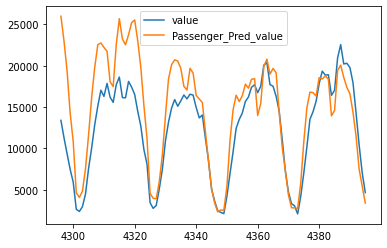

In [56]:
df_final[['value','Passenger_Pred_value']][:100].plot()

In [ ]:
import numpy as np
import pandas as pd
df_final = pd.DataFrame(df_final, columns=['Passenger_Pred_value','value']).to_csv('prediction_ARMIMA.csv')
#### 가중치 더 나은쪽으로..! 